#### Import Library

In [ ]:
# library
import torch
import torch.nn.functional as F
from torch import nn,optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models
from torch.optim import SGD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import os
from PIL import Image

# parameters
torch.manual_seed(1)
batch_size = 20

#### Read data from images and excel-labels

In [ ]:
# read the images and names
IMAGE_DIR =  'Data/C_img_jpg'
def read_images(image_path=IMAGE_DIR):
    images = []
    images_names = [image for image in os.listdir(image_path) if not image.startswith('.')] 
    for image_name in images_names: 
            img = Image.open (os.path.join(image_path, image_name))
            images.append(img)
    return images,images_names
images,names = read_images()

In [ ]:
# read the label
excel=pd.read_csv('Data/C_all_data_add_20211007_xz.csv', encoding = 'gb2312')
excel = np.array(excel)
excel = excel.tolist()
# Alligning the labels with images. (i.e. the first label corresponds to the first label.)
labels = []
sub_labels = []

for i in range(len(names)):
    for j in range(len(excel)):
        if names[i] == excel[j][0]:
            labels.append(excel[j][1])
            sub_labels.append(excel[j][2:])


#### Split the training and testing dataet

In [ ]:
# Stratified Random Sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.2,random_state = 42)

names = np.array(names)
labels = np.array(labels)
names = names.reshape((names.shape[0],-1))
labels = labels.reshape((labels.shape[0],-1))
data = np.hstack((names,labels)) # hstack:each name corresponds to one label 
for train_index,test_index in split.split(data,data[:,-1]):
    train_set = data[train_index,:]
    test_set = data[test_index,:]

#### Data Preprocessing

In [ ]:
# data trsnformation
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       
                                       ])
train_data_1 = []
train_data_3 = []
for row in range(len(train_set)):
    for i in range(len(names)):
        if names[i] == train_set[row][0]: 
            img_data = train_transforms(images[i]) 
            # train_set is [names, labels], we need to get the train_data_1 [images, labels], train_data_3 [images, sub_labels, labels]
            train_data_1.append((img_data,int(train_set[row][1]))) 
            train_data_3.append((img_data,torch.Tensor(sub_labels[i][:]),int(train_set[row][1])))

test_transforms =  transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       
                                       ])
test_data_1 = []
test_data_3 = []
for row in range(len(test_set)):
    for i in range(len(names)):
        if names[i] == test_set[row][0]:
            img_data = test_transforms(images[i])
            test_data_1.append((img_data,int(test_set[row][1]))) 
            test_data_3.append((img_data,torch.Tensor(sub_labels[i][:]),int(train_set[row][1])))

In [ ]:
# data loader
train_loader_3=DataLoader(train_data_3 , batch_size=batch_size ,shuffle=True)
test_loader_3=DataLoader(test_data_3, batch_size=int(batch_size*test_size/(1-test_size)),shuffle=False )

#### Load the Network

In [ ]:
# model-2
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=7):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self. fc = nn.Linear(hidden_size, 7)


    def forward(self, x):
        out= self.fc1(x)
        out= self.relu(out)
        out= self.dropout(out)
        out= self.fc2(out)
        out= self.relu(out)
        out= self.fc(out)
        return out

In [ ]:
"""
original code from rwightman:
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""
from functools import partial
from collections import OrderedDict

import torch
import torch.nn as nn


def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, embed_dim=128, norm_layer=None):
        super().__init__()
        '''img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)'''
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        '''B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C'''
        #x = x.transpose(1, 2)  #[B,2,128]
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.1,
                 proj_drop_ratio=0.1):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim] [B, 3, 128]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim][B, 3, 3*128]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads /8, num_patches + 1 /3, embed_dim_per_head /16]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head] [B,8,3,16]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1] [B,8,3,3]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, num_classes=7, embed_dim=128, depth=12, num_heads=8, mlp_ratio=4.0,num_patches=8, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.3,
                 attn_drop_ratio=0.3, drop_path_ratio=0.3, embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(embed_dim=embed_dim)
        

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 2, 128]
        # [1, 1, 128]-> [B, 1, 128]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)  # [B, 3, 128]
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(m):
    """
    ViT weight initialization
    :param m: module
    """
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)
        

In [ ]:
# fmodel: fusion transformer model
# from fusiontransformer_vit import vit_base_patch16_224 as f
device = torch.device("cuda")
fmodel = VisionTransformer().to(device)

# model-1: resnet18
model_1 = torch.load('model_1_分层.pth',map_location=device).to(device)
# model-2: DNN
model_2=Net(6, 512, 7).to(device)
model_2.load_state_dict(torch.load('model_2_param.pkl',map_location=device))
#model_2 = torch.load('model_2_分层.pth',map_location=device).to(device)

#### Train the Network

In [ ]:
# complex
import complexPyTorch
from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
from complexPyTorch.complexLayers import ComplexDropout2d, NaiveComplexBatchNorm2d
from complexPyTorch.complexLayers import ComplexBatchNorm1d
from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d
iscomplex = True

In [ ]:
# extract features
def my_forward(model, x):
    mo = nn.Sequential(*list(model.children())[:-1])
    feature = mo(x)
    feature = feature.view(x.size(0), -1)
    output= model.fc(feature)
    return feature, output

In [ ]:
# fmodel training
learning_rate = 0.02
num_epoches = 20
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)     # 设置学习率下降策略
optimizer=optim.SGD(fmodel.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()

train_loss_all = []   # store the loss of training set
train_accur_all = []  # store the accuracy of training set
test_loss_all = []    # store the loss of test set
test_accur_all = []   # store the accuracy of test set
model_1.eval()
model_2.eval()
#开始训练
for epoch in range(num_epoches):
    
    running_loss=0.0
    running_acc=0.0
    fmodel.train()
    for i,data in enumerate(train_loader_3,1):
        img_plus,label=data
        img=img_plus[1]
        sub_label=img_plus[0]
        img=Variable(img).to(device)
        sub_label = sub_label.float()
        label=Variable(label).to(device)
        sub_label=sub_label.to(device)
        #forward
        feature_1, out1 = my_forward(model_1,img)
        feature_2, out2 = my_forward(model_2,sub_label)
        #out1=model_1(img)
        #out2=model_2(sub_label)
        if iscomplex:
            feature_1 = feature_1.unsqueeze(1)
            feature_2 = feature_2.unsqueeze(1)
            input3 = torch.cat((feature_1,feature_2),1)
        else:    
            cca = CCA(n_components = 2)
            out1 = out1.cpu()
            out2 = out2.cpu()
            out1 = out1.detach().numpy()
            out2 = out2.detach().numpy()
            cca.fit(out1, out2)
            X_c, Y_c = cca.transform(out1, out2)
            input3 = torch.Tensor(np.hstack((X_c,Y_c))).to(device)
        out = fmodel(input3)
        print(label.shape)
        loss = criterion(out,label)
        running_loss += loss.data*label.size(0)
        _,pred = torch.max(out,1)
        num_correct = (pred==label).sum()
        running_acc += num_correct.data
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Train {} epoch, Loss: {:.6f},Acc: {:.6f}'.format(epoch+1,running_loss/(len(train_data_3)),running_acc/len(train_data_3)))
    train_loss_all.append(running_loss / len(train_data_3))   # store the loss of training set, and then plot it
    train_accur_all.append(running_acc/len(train_data_3))     # store the accuracy of training set, and then plot it
    #scheduler.step() # update the learning rate
    
    fmodel.eval()
    with torch.no_grad():
        eval_loss = 0
        eval_acc = 0
        train_loss_results = []

        for data in test_loader_3:
            img_plus,label=data
            img=img_plus[1]
            sub_label=img_plus[0]
            img=Variable(img).to(device)
            sub_label = sub_label.float()
            label=Variable(label).to(device)
            sub_label=sub_label.to(device)
            # forward
            feature_1, out1 = my_forward(model_1,img)
            feature_2, out2 = my_forward(model_2,sub_label)
            if iscomplex:
                feature_1 = feature_1.unsqueeze(1)
                feature_2 = feature_2.unsqueeze(1)
                input3 = torch.cat((feature_1,feature_2),1)
            else:
                cca = CCA(n_components = 2)
                out1 = out1.cpu()
                out2 = out2.cpu()
                out1 = out1.detach().numpy()
                out2 = out2.detach().numpy()
                cca.fit(out1, out2)
                X_c, Y_c = cca.transform(out1, out2)
                input3 = torch.Tensor(np.hstack((X_c,Y_c))).to(device)
            out = fmodel(input3)
            loss = criterion(out, label)
            eval_loss += loss.data
            _,pred = torch.max(out,1)
            num_correct = (pred == label).sum()
            eval_acc += num_correct.data

    print('Test Loss: {:,.6f}, Acc: {:,.6f}'.format(eval_loss/(len(test_data_1)), eval_acc/(len(test_data_1))))
    test_loss_all.append(eval_loss/(len(test_data_1)))
    test_accur_all.append(eval_acc/(len(test_data_1)))

torch.Size([50, 1])


RuntimeError: multi-target not supported at /opt/conda/conda-bld/pytorch_1607370117127/work/aten/src/THCUNN/generic/ClassNLLCriterion.cu:15

#### Result Visualization

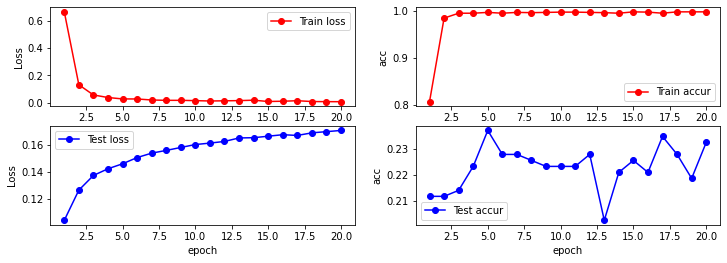

In [ ]:
# 数据准备，转移到CPU
for i in range(len(train_loss_all)):
    train_loss_all[i] = torch.Tensor.cpu(train_loss_all[i])
    train_accur_all[i] = torch.Tensor.cpu(train_accur_all[i])
    test_loss_all[i] = torch.Tensor.cpu(test_loss_all[i])
    test_accur_all[i] = torch.Tensor.cpu(test_accur_all[i])

epoches = [i+1 for i in range(num_epoches)]

# 画图可视化
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(epoches, train_loss_all,"ro-", label="Train loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(epoches, train_accur_all,"ro-", label="Train accur")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(epoches, test_loss_all,"bo-", label="Test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(epoches, test_accur_all,"bo-", label="Test accur")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

#### Save the model


In [ ]:
# save fmodel
torch.save(fmodel, 'fmodel_name.pth')